# 2. Debug Training Jobs with SageMaker Debugger

* Goals:
    1. Train an XGBoost classification model using the `sagemaker.estimator.Estimator` class.
    2. Use SageMaker Debugger and built-in Rules to debug training jobs.
    3. Analyze metrics and metadata collected during training.
* Code adapted from the following sample notebooks:
    * [xgboost_customer_churn_studio](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/aws_sagemaker_studio/getting_started/xgboost_customer_churn_studio.ipynb) 
    * [xgboost-regression-debugger-rules](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-debugger/xgboost_builtin_rules/xgboost-regression-debugger-rules.ipynb)

---
## 1. Setup

Change into the notebooks directory.

In [3]:
%cd /root/sagemaker-workshop-420/notebooks

/root/sagemaker-workshop-420/notebooks


In [4]:
import pandas as pd

import boto3
import sagemaker
from sagemaker import get_execution_role

Setup S3 paths and local paths to use for the notebook.

In [5]:
BUCKET = 'sagemaker-workshop-420'
PREFIX = 'xgb-churn'

LOCAL_DATA_DIRECTORY = f'../data/{PREFIX}'

print(f"Artifacts will be written to s3://{BUCKET}/{PREFIX}")

Artifacts will be written to s3://sagemaker-workshop-420/xgb-churn


First, lets create our Sagemaker session and role.

In [6]:
boto_session = boto3.Session()
region = boto_session.region_name
sagemaker_session = sagemaker.Session()
role = get_execution_role()
print(role)

arn:aws:iam::209970524256:role/service-role/AmazonSageMaker-ExecutionRole-20200414T065516


---
## 2. Data

Mobile operators have historical records that tell them which customers ended up churning and which continued using the service. We can use this historical information to train an ML model that can predict customer churn. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model to have the model predict whether this customer will churn. 

The dataset we use is publicly available and was mentioned in [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets. The `data` folder that came with this notebook contains the dataset, which we've already preprocessed for this walkthrough. The dataset has been split into training and validation sets. To see how the dataset was preprocessed, see this notebook: [XGBoost customer churn notebook that starts with the original dataset](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb). 

We'll train on a .csv file without the header. But for now, the following cell uses `pandas` to load some of the data from a version of the training data that has a header. 

Explore the data to see the dataset's features and the data that will be used to train the model.

In [7]:
# Set the path we can find the data files that go with this notebook
local_data_path = f'{LOCAL_DATA_DIRECTORY}/training-dataset-with-header.csv'
data = pd.read_csv(local_data_path)
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 10)         # Keep the output on one page
data

,Churn,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area Code_408,Area Code_415,Area Code_510,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
0,0,106,0,274.4,120,198.6,82,160.8,62,6.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
1,0,28,0,187.8,94,248.6,86,208.8,124,10.6,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
2,1,148,0,279.3,104,201.6,87,280.8,99,7.9,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,0,132,0,191.9,107,206.9,127,272.0,88,12.6,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
4,0,92,29,155.4,110,188.5,104,254.9,118,8.0,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,0,106,0,194.8,133,213.4,73,190.8,92,11.5,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0
2329,1,125,0,143.2,80,88.1,94,233.2,135,8.8,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
2330,0,129,0,143.7,114,297.8,98,212.6,86,11.4,8,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0
2331,0,159,0,198.8,107,195.5,91,213.3,120,16.5,7,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0


Now we'll upload the files to S3 for training. Since we're training with the CSV file format, we'll create `s3_input` objects that our training function can use as a pointer to the files in S3.

In [8]:
s3_input_train = sagemaker_session.upload_data(f'{LOCAL_DATA_DIRECTORY}/train.csv',
                                               bucket=BUCKET,
                                               key_prefix=PREFIX)

s3_input_validation = sagemaker_session.upload_data(f'{LOCAL_DATA_DIRECTORY}/validation.csv',
                                                    bucket=BUCKET,
                                                    key_prefix=PREFIX)

s3_input_train = sagemaker.s3_input(s3_data=s3_input_train, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=s3_input_validation, content_type='csv')

---
## 3. Train

We'll use the XGBoost library to train a class of models known as gradient boosted decision trees on the data that we just uploaded.

Rather than provide a custom training script as we did in the previous notebook on sklearn, we'll use the [built-in XGBoost algorithm](https://sagemaker.readthedocs.io/en/stable/using_xgboost.html#use-xgboost-as-a-built-in-algortihm). The built-in algorithms don't require custom training scripts.

However they do require you to specify the location of the XGBoost algorithm Docker image and the version you wish to use. SageMaker provides a helper function to retrive image URIs.

In [9]:
from sagemaker.amazon.amazon_estimator import get_image_uri
xgboost_image_name = get_image_uri(boto_session.region_name, 'xgboost', repo_version='0.90-2')
xgboost_image_name

'257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

In [11]:
hyperparams = {"max_depth":5,
               "subsample":0.8,
               "num_round":600,
               "eta":0.2,
               "gamma":4,
               "min_child_weight":6,
               "silent":0,
               "objective":'binary:logistic'}

xgb = sagemaker.estimator.Estimator(image_name=xgboost_image_name,
                                    role=role,
                                    hyperparameters=hyperparams,
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=f"s3://{BUCKET}/{PREFIX}",
                                    base_job_name="xgboost-churn-builtin",
                                    sagemaker_session=sagemaker_session)

xgb.fit({'train': s3_input_train,
         'validation': s3_input_validation})

2020-04-15 10:47:41 Starting - Starting the training job...
2020-04-15 10:47:42 Starting - Launching requested ML instances...
2020-04-15 10:48:41 Starting - Preparing the instances for training......
2020-04-15 10:49:32 Downloading - Downloading input data...
2020-04-15 10:49:50 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[10:50:24] 2333x69 matrix with 160977 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter of CS

## 4. Debug training jobs with Amazon SageMaker Debugger

Amazon SageMaker Debugger lets you debug a model during training. As you train, Debugger periodicially saves tensors, which fully specify the state of the model at that point in time. Debugger saves the tensors to an Amazon S3 bucket. You can then use Amazon SageMaker Studio for analysis and visualization to diagnose training issues.

### 4a. Specify SageMaker Debugger Rules

To enable automated detection of common issues during training, Amazon SageMaker Debugger also allows you to attach a list of rules to evaluate the training job against. Built-in rules are created by the data science and engineering teams in Amazon SageMaker which you can opt to evaluate against your training job. You can optionally choose to write your own rule as a Python source file and have it evaluated against your training job. To provide Amazon SageMaker Debugger to evaluate this rule, you would have to provide the S3 location of the rule source and the evaluator.

Some rules that apply to XGBoost include `AllZero`, `ClassImbalance`, `Confusion`, `LossNotDecreasing`, `Overfit`, `Overtraining`, `SimilarAcrossRuns`, `TensorVariance`, `UnchangedTensor`, and `TreeDepth`. See the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html) for a description of all built-in Rules.

We'll use the `LossNotDecreasing`, `Overtraining`, and the `Overfit` rules. The `LossNotDecreasing` rule is triggered if the loss doesn't decrease monotonically at any point during training.

To configure rules, we call the `sagemaker.debugger.Rule.sagemaker` function. Parameters to the function include:
* `base_config`: the base rule config returned from the built-in list of rules.
* `rule_parameters`: A dictionary of parameters for the rule. In this example, you will use Amazon SageMaker's `LossNotDecreasing` rule to monitor the `metrics` collection every 10 steps. The rule will alert you if the tensors in `metrics` has not decreased for more than 10 steps.

In [15]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig

In [16]:
debug_rules = [Rule.sagemaker(rule_configs.loss_not_decreasing(),
                              rule_parameters={
                                  "collection_names": "metrics",     # Which parameters to monitor.
                                  "num_steps": '10',                 # How often, in steps, to save tensors.
                              }),
               Rule.sagemaker(rule_configs.overtraining()),
               Rule.sagemaker(rule_configs.overfit())]

### 4b. Create a DebuggerHookConfig

Enabling Amazon SageMaker Debugger in training job can be accomplished by adding its configuration into Estimator object constructor:

```python
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

estimator = Estimator(
    ...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "10"
                }
            )
        ]
    )
)
```
Here, the `DebuggerHookConfig` object tells the `Estimator` object what data we're interested in. Two parameters are provided in the example:

- `s3_output_path`: it points to S3 bucket/path where we intend to store our debugging tensors.
  Amount of data saved depends on multiple factors, major ones are: training job / data set / model / frequency of saving tensors.
  This bucket should be in your AWS account, and you should have full access control over it.
  **Important Note**: this s3 bucket should be originally created in the same region where your training job will be running, otherwise you might run into problems with cross region access.

- `collection_configs`: it enumerates named collections of tensors we want to save.
  Collections are a convenient way to organize relevant tensors under same umbrella to make it easy to navigate them during analysis.
  In this particular example, you are instructing Amazon SageMaker Debugger that you are interested in a single collection named `metrics`.
  We also instructed Amazon SageMaker Debugger to save metrics every 10 iteration.
  See [Collection](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#collection) documentation for all parameters that are supported by Collections and DebuggerConfig documentation for more details about all parameters DebuggerConfig supports.

In [17]:
debug_hook_config = DebuggerHookConfig(
    s3_output_path = f's3://{BUCKET}/{PREFIX}',  # Required
    collection_configs = [
        CollectionConfig(
            name="metrics",                      # the evaluation metrics computed by xgboost.
            parameters={"save_interval": '5'}    # How often, in steps, to save tensors.
        ),
        CollectionConfig(
            name="feature_importance",           # Feature importance given by get_score()
            parameters={"save_interval": '5'}
        ),
        CollectionConfig(
            name="average_shap",                 # The sum of SHAP value magnitudes over all samples. Represents the impact each feature has on the model output. 
            parameters={"save_interval": '5'}   
        ),
    ]
)

### 4c. Enabling Debugger in Estimator object

We now pass both the `DebuggerHookConfig` and our list of rules to the `Estimator` constructor. That's it!

In [18]:
debug_xgb = sagemaker.estimator.Estimator(
    image_name=xgboost_image_name,
    role=role,
    hyperparameters=hyperparams,
    train_instance_count=1, 
    train_instance_type='ml.m4.xlarge',
    output_path=f"s3://{BUCKET}/{PREFIX}",
    base_job_name="DEBUG-xgboost-churn-builtin",
    sagemaker_session=sagemaker_session,
    # Define debug configuration
    debugger_hook_config = debug_hook_config,
    # Define rules to monitor
    rules=debug_rules)

debug_xgb.fit({'train': s3_input_train,
               'validation': s3_input_validation})

2020-04-15 10:55:55 Starting - Starting the training job...
2020-04-15 10:56:22 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*       Overtraining: InProgress        
*            Overfit: InProgress        
*
****************************************
......
2020-04-15 10:57:23 Starting - Preparing the instances for training......
2020-04-15 10:58:24 Downloading - Downloading input data...
2020-04-15 10:58:44 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is

In [23]:
debug_xgb.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:209970524256:processing-job/debug-xgboost-churn-builti-lossnotdecreasing-2c17c011',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule LossNotDecreasing at step 30 resulted in the condition being met\n',
  'LastModifiedTime': datetime.datetime(2020, 4, 15, 11, 1, 7, 165000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overtraining',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:209970524256:processing-job/debug-xgboost-churn-builti-overtraining-da794617',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2020, 4, 15, 11, 1, 7, 165000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:209970524256:processing-job/debug-xgboost-churn-builti-overfit-003fd8a8',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime'

## 5. Analyze data captured by Debugger

Now that you've trained the model, you can analyze the data captured by Debugger. Here, you focus on after-the-fact analysis that will help you fix the training procedure.

You import an analysis library called `smdebug` which defines the concept of trial. A trial represents a single training run. We'll discuss Trials more in the next notebook.

In [24]:
from smdebug.trials import create_trial

In [25]:
trial = create_trial(debug_xgb.latest_job_debugger_artifacts_path())

[2020-04-15 11:02:25.178 ce65290b14fe:96 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-workshop-420/xgb-churn/DEBUG-xgboost-churn-builtin-2020-04-15-10-55-55-549/debug-output
[2020-04-15 11:02:25.429 ce65290b14fe:96 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 10144 more expected)', IncompleteRead(0 bytes read, 10144 more expected)) while reading s3://sagemaker-workshop-420/xgb-churn/DEBUG-xgboost-churn-builtin-2020-04-15-10-55-55-549/debug-output/index/000000000/000000000040_worker_0.json . Will retry now


You can list all the tensors that you know something about. Each one of these names is the name of a tensor. The name is a combination of the feature name, which in these cases, is auto-assigned by XGBoost, and whether it's an evaluation metric, feature importance, or SHAP value.

In [26]:
trial.tensor_names()

[2020-04-15 11:02:29.751 ce65290b14fe:96 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-04-15 11:02:30.766 ce65290b14fe:96 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f21',
 'average_shap/f22',
 'average_shap/f23',
 'average_shap/f24',
 'average_shap/f25',
 'average_shap/f26',
 'average_shap/f27',
 'average_shap/f28',
 'average_shap/f29',
 'average_shap/f3',
 'average_shap/f30',
 'average_shap/f31',
 'average_shap/f32',
 'average_shap/f33',
 'average_shap/f34',
 'average_shap/f35',
 'average_shap/f36',
 'average_shap/f37',
 'average_shap/f38',
 'average_shap/f39',
 'average_shap/f4',
 'average_shap/f40',
 'average_shap/f41',
 'average_shap/f42',
 'average_shap/f43',
 'average_shap/f44',
 'average_shap/f45',
 'average_shap/f46',
 'average_shap/f47',
 'average_shap/f48',
 'average_shap/f49',
 'average_shap/f5',
 'average_shap/f50',
 'average_shap/f51'

For each tensor, ask for the steps where you have data. In this case, every five steps

In [27]:
train_error = trial.tensor("train-error")

steps = train_error.steps()
# You can obtain each tensor at each step as a NumPy array.
values = train_error.values()

In [28]:
print(steps[:10])
print([values[s][0] for s in steps[:10]])

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
[0.077154, 0.046721, 0.040291, 0.039434, 0.039434, 0.034291, 0.033862, 0.033862, 0.031719, 0.03129]


### 5a. Analyze Performance metrics

You can also create a simple function that visualizes the training and validation errors as the training progresses.
Each gradient should get smaller over time, as the system converges to a good solution.
Remember that this is an interactive analysis. You are showing these tensors to give an idea of the data.

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline 


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

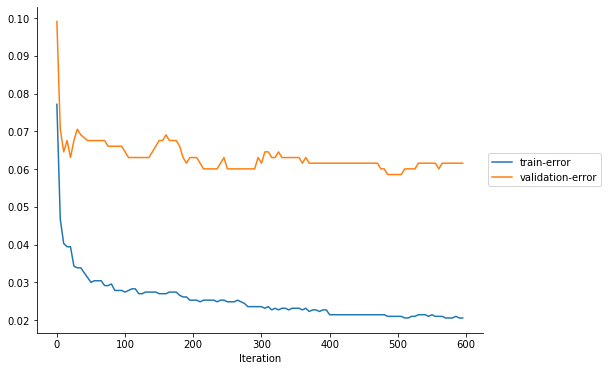

In [83]:
plot_collection(trial, "metrics")

### 5b. Analyze Feature importances

You can also visualize the feature priorities as determined by
[xgboost.get_score()](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score).
If you instructed Estimator to log the `feature_importance` collection, all five importance types supported by `xgboost.get_score()` will be available in the collection.

In [57]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

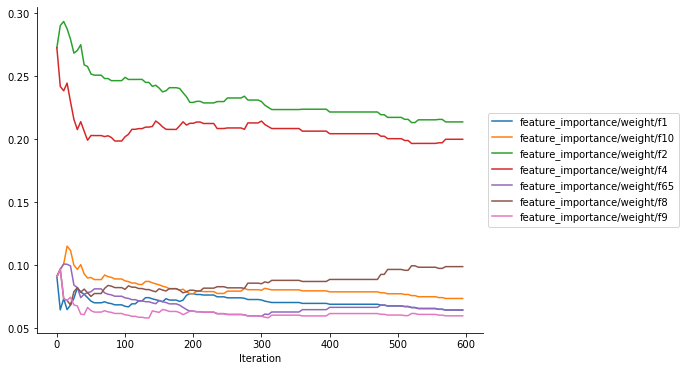

In [58]:
plot_feature_importance(trial)

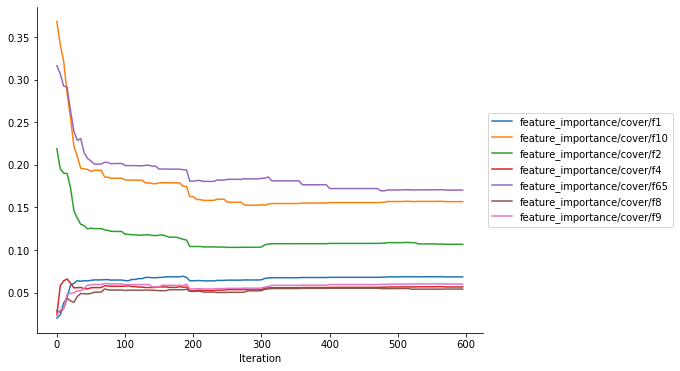

In [59]:
plot_feature_importance(trial, importance_type="cover")

#### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is
another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output.
You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by [xgboost.predict(pred_contribs=True)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict)) will be available the `average_shap` collection.

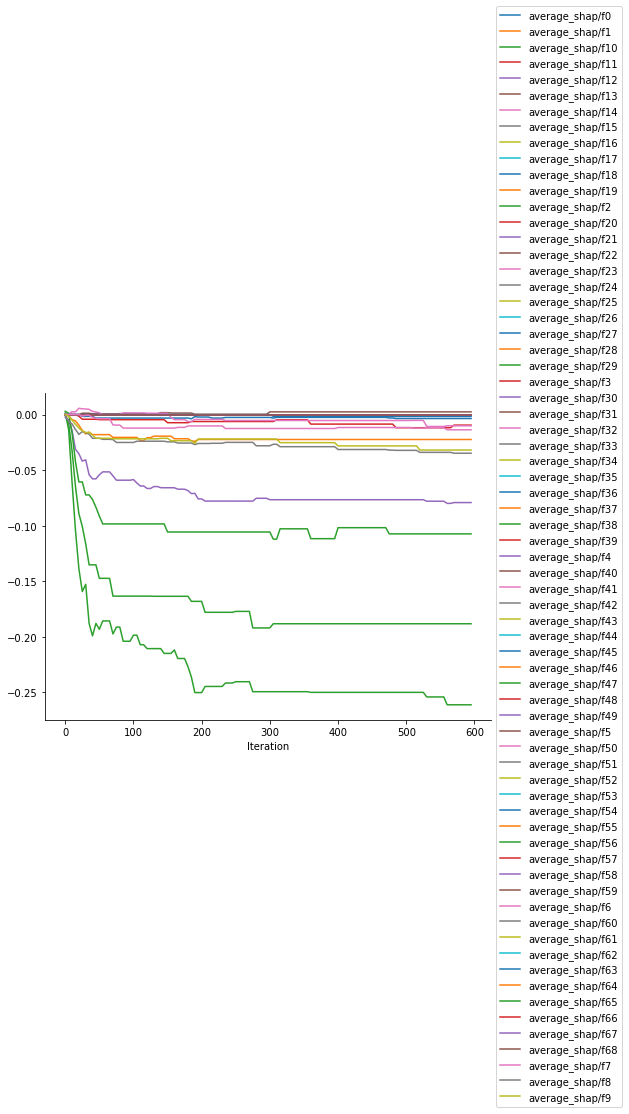

In [60]:
plot_collection(trial, "average_shap")